# Melanoma Detection Assignment

## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Step 1: Understanding the dataset

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing skin cancer dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [47]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
print(data_dir_train.exists())
print(data_dir_test.exists())

True
True


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
batch_shape = (batch_size, img_height, img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels = 'inferred',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = 123,
    validation_split = 0.2,
    subset = "training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels = 'inferred',
    batch_size = batch_size,
    image_size = (img_height,img_width),
    seed = 123,
    validation_split = 0.2,
    subset = "validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


# Step 2: Visualize the data

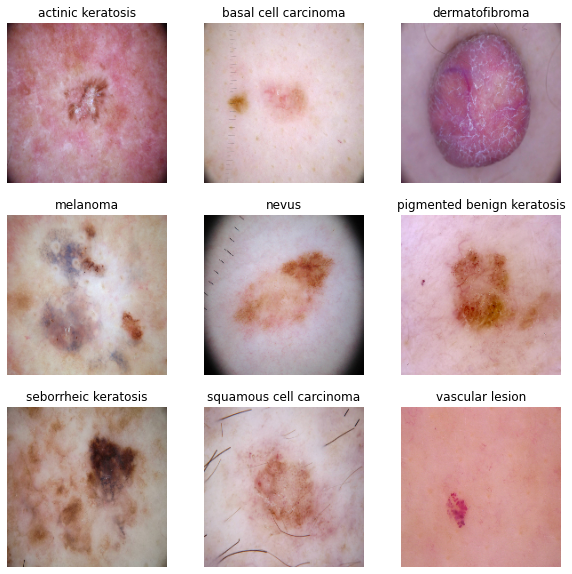

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize = (10,10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

# Step 3: Model Building and Training

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
rescale = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))

normalized_ds = train_ds.map(lambda x, y: (rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13970587 0.9763074


In [13]:

model = tf.keras.Sequential([
  rescale,
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 74s 1s/step - loss: 2.0097 - accuracy: 0.2433 - val_loss: 1.8446 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6652 - accuracy: 0.3917 - val_loss: 1.5153 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5093 - accuracy: 0.4654 - val_loss: 1.6160 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4150 - accuracy: 0.4994 - val_loss: 1.4824 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3414 - accuracy: 0.5318 - val_loss: 1.5140 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2558 - accuracy: 0.5513 - val_loss: 1.4013 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2087 - accuracy: 0.5742 - val_loss: 1.3670 - val_accuracy: 0.5391
Epoch 8/20
56/

### Visualizing training results

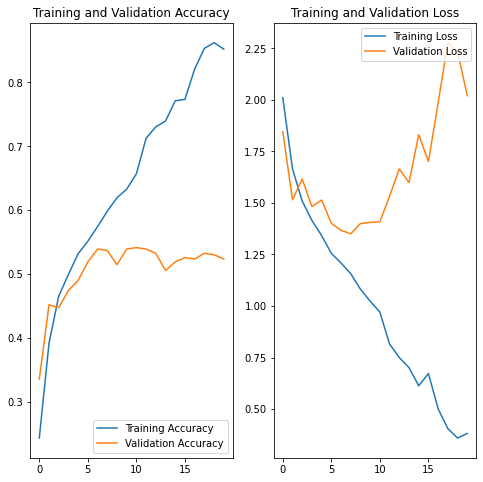

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis of Model 1

We can clearly see that the training accuracy is way more than the validation accuracy. This means that the model is trying to learn the training data. This means that the model is clearly overfitting.

# Step 4: Data augmentation to resolve underfitting/overfitting 

### Data Augmentation

In [18]:
# Choosing an appropriate data augumentation strategy. 
data_augmentation = Sequential([tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),
                                tf.keras.layers.experimental.preprocessing.RandomFlip(),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)])


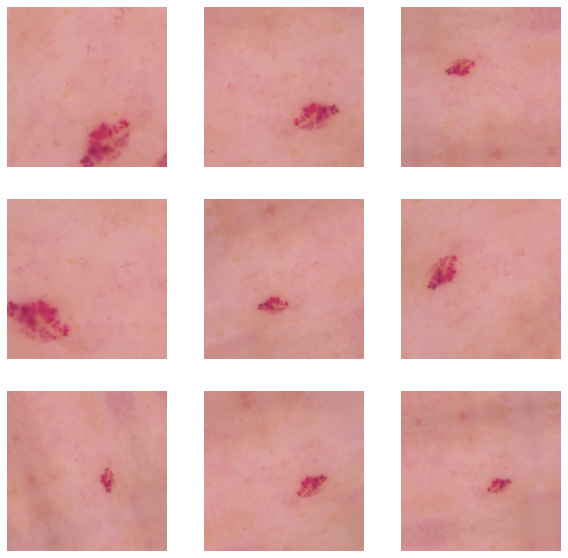

In [19]:
# visualization of how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

# Step 5: Model Building & training on the augmented data

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model2 = Sequential()

model2.add(Sequential(data_augmentation))

model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))


model2.add(tf.keras.layers.Conv2D(16, 3, activation='relu', batch_input_shape=batch_shape))
model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(num_classes))


### Compiling the model

In [21]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model2.build(batch_shape)

In [23]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 178, 178, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 89, 89, 16)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 87, 87, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 28ms/step - loss: 2.0484 - accuracy: 0.2472 - val_loss: 1.8156 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7697 - accuracy: 0.3510 - val_loss: 1.8888 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.6672 - accuracy: 0.4090 - val_loss: 1.6563 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.5764 - accuracy: 0.4286 - val_loss: 1.4803 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5198 - accuracy: 0.4621 - val_loss: 1.4448 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4845 - accuracy: 0.4721 - val_loss: 1.4340 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4262 - accuracy: 0.4927 - val_loss: 1.3629 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing the results

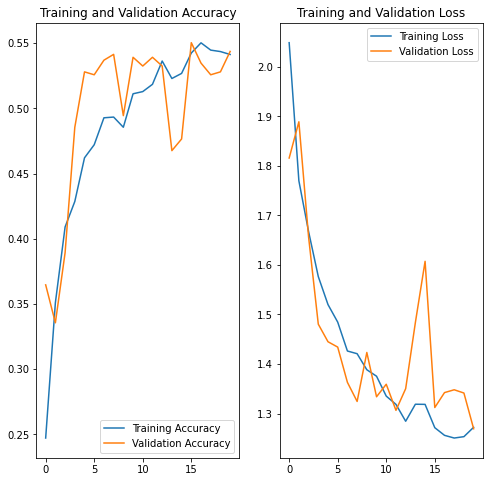

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis of Model 2

1. There is a significant improvement in the validation accuracy  of the model and is on par with the training accuracy. However there is still certain loss during validation.
2. The training and validation accuracy are in between 50%-55%.
3. The data augmentation has resolved overfitting, but now the model is underfitting as values are smaller than before.

# Step 6: Class distribution

#### Find the distribution of classes in the training dataset.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
classDictionary = {}
trainDatapath = pathlib.Path("gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")


for class_name in class_names:
  class_data_path = pathlib.Path(trainDatapath).joinpath(class_name)
  num_images = len(list(class_data_path.glob('*.jpg')))
  classDictionary[class_name] = num_images

classDictionary

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [27]:
class_df = pd.DataFrame(classDictionary.values(), index=classDictionary.keys(), columns=['No of images'])
class_df

,No of images
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


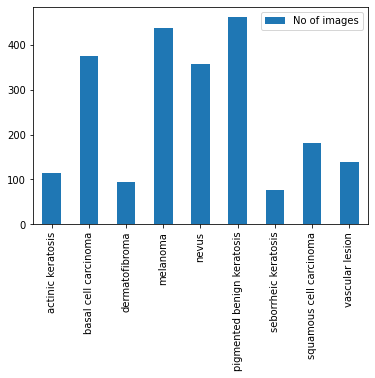

In [28]:
class_df.plot.bar()
plt.show()

#### Findings: 
We can see that there is an imbalance of the classes present in the dataset. There are certain classes having large data, when compared to others.
#### - Which class has the least number of samples?
seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis

# Step 7: Handling class imbalances

#### Rectify the class imbalance
Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF0741C0B90>: 100%|██████████| 500/500 [00:20<00:00, 23.89 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF07402F2D0>: 100%|██████████| 500/500 [00:21<00:00, 23.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF0740A1050>: 100%|██████████| 500/500 [00:26<00:00, 18.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF07413F4D0>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FF0764A3650>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF107934B10>: 100%|██████████| 500/500 [00:19<00:00, 25.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF074042A50>: 100%|██████████| 500/500 [00:43<00:00, 11.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF074098D50>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF08A366D50>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_b2c6d409-4a6e-41f1-82f7-a09c80a6e206.jpg',
 'gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_c1bb2740-0e93-4851-9fab-a01065774572.jpg',
 'gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_dabc77b0-eb5e-4e86-9516-546e36c37302.jpg',
 'gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011030.jpg_123f40c4-f197-48eb-9997-cc4dad9fd133.jpg',
 'gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [44]:
new_df['Label'].value_counts()

Train                         2239
seborrheic keratosis           500
basal cell carcinoma           500
melanoma                       500
dermatofibroma                 500
nevus                          500
vascular lesion                500
squamous cell carcinoma        500
actinic keratosis              500
pigmented benign keratosis     500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Step 8: Model Building & training on the rectified class imbalance data

#### Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [48]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
rescale = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))

normalized_ds = train_ds.map(lambda x, y: (rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.15294124 0.932353


In [52]:
model = Sequential([
  rescale,
  layers.Conv2D(8, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 8)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                  

#### Train your model

In [54]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 11s 57ms/step - loss: 1.9269 - accuracy: 0.2520 - val_loss: 1.7461 - val_accuracy: 0.3437
Epoch 2/30
169/169 [==============================] - 4s 21ms/step - loss: 1.6144 - accuracy: 0.3676 - val_loss: 1.5262 - val_accuracy: 0.4432
Epoch 3/30
169/169 [==============================] - 3s 20ms/step - loss: 1.4960 - accuracy: 0.4216 - val_loss: 1.5046 - val_accuracy: 0.4655
Epoch 4/30
169/169 [==============================] - 3s 20ms/step - loss: 1.4154 - accuracy: 0.4544 - val_loss: 1.5032 - val_accuracy: 0.4529
Epoch 5/30
169/169 [==============================] - 3s 20ms/step - loss: 1.3422 - accuracy: 0.4742 - val_loss: 1.3111 - val_accuracy: 0.5041
Epoch 6/30
169/169 [==============================] - 3s 20ms/step - loss: 1.2510 - accuracy: 0.5159 - val_loss: 1.2814 - val_accuracy: 0.5115
Epoch 7/30
169/169 [==============================] - 3s 21ms/step - loss: 1.1686 - accuracy: 0.5497 - val_loss: 1.1601 - val_accuracy: 0.575

#### Visualize the model results

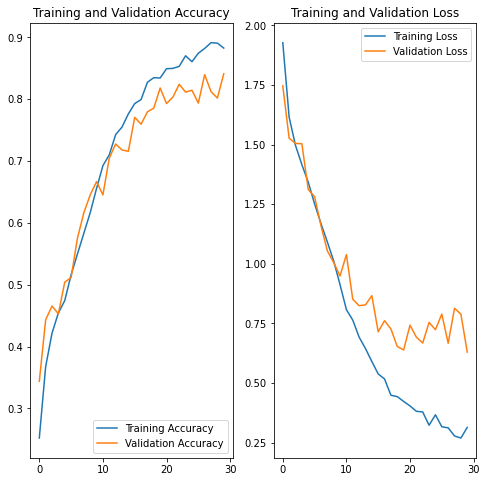

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis of Model 3

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. The accuracy has overshooted to **80-90%** from previous model which was 50-55%.
2. The class rebalancing has worked and has helped in getting rid of overfitting.